# Trabalho #1 - MC906
### Integrantes do grupo
164213 Andreza Aparecida dos Santos

166301 Daniela Palumbo

160160 Guilherme Furlan

172655 Lucas Cunha

187506 Thamiris Coelho


In [1]:
import sys
import random
import math
import matplotlib.pyplot as plt
PATH_TO_AIMA = "../aima-python"
if PATH_TO_AIMA not in sys.path:
    sys.path.insert(0,PATH_TO_AIMA)
from search import *
import timeit
import walls

In [2]:
# Global maze declaration
maze_array = None
time_measure = {
    "BFS": [],
    "DLS": [],
    "ASL": [],
    "ASM": [],
    "ASIM": [],
    "GL": [],
    "GM": [],
    "GIM": [],
    "HC": [],
    "pacman_initials": [],
    "goal_positions": [],
}
total_visited_nodes = {
    "BFS": [],
    "DLS": [],
    "ASL": [],
    "ASM": [],
    "ASIM": [],
    "GL": [],
    "GM": [],
    "GIM": [],
    "HC": [],
}

## Definição do Objetivo do Trabalho

O  Pac-man  encontra-se  em  um  labirinto  composto  pelas paredes, 3 fantasmas estáticos em posições pré-definidas, um ponto objetivo e dots. O objetivo desse trabalho é levar o Pac-man até o ponto objetivo.
O Pac-man  se  move  de  acordo  com  vizinhança-4,  a  cada  ação executada  ele  coleta  um  dot  do  labirinto  e  revisitar  posições não é permitido. 

O labirinto é representado como uma grid de tamanho variável. As paredes do labirinto são intransponíveis e o ambiente é completamente observável, determinıstico, sequencial, estático e discreto.

## Problem Modeling

Para modelar o problema utilizamos a classe "Problem" presente na biblioteca AIMA.search[1] em Python 3.

Definimos as seguintes propriedades do problema:
- O labirinto é global
- Os estados são uma tupla (x,y,z) de modo que x e y representam a posição do Pac-man no labirinto e z a quantidade de dots comidos.
- As possíveis ações são tuplas (x,y) nas direções Oeste, Norte, Sul e Leste, que são testadas nessa ordem.
- A posição inicial do Pac-man é gerada aleatoriamente dentro das possíveis posições¹.
- A posição do objetivo é gerada aleatoriamente dentro das possíveis posições¹.
- As posições dos fantasmas são geradas aleatoriamente dentro das possíveis posições¹.

¹ posições possíveis são posições representadas por dots na geração do labirinto.

A modelagem foi feita definindo as funções abaixo.
- actions: Determina a partir da posição (x,y) do Pac-man e do estado do labirinto quais ações são possíveis de serem executadas.
- result: Retorna o novo estado do Pac-man após executar uma ação.
- goaltest: Testa se o Pac-man chegou no objetivo.
- pathcost: Determina o custo para cada ação executada. Para o nosso caso, cada passo dado pelo Pac-man tem custo 1.
- value: Retorna quantos dots foram coletados. É utilizada no algoritmo de busca local para ser maximizada.



In [3]:
class PacmanMazeProblem(Problem):
    """The Pac-man Maze Problem."""
    
    def __init__(self, pac_position, goal_position):
        Problem.__init__(self, pac_position, goal_position)
        
    def actions(self, state):
        """The possible actions include the neighbor positions of a given node
        except if the position is a ghost or a wall"""        
        actions = []
        y, x, _ = state
        directions = [         (0, -1),
                      (-1, 0),           (1,  0),
                                (0, 1)           ]
        for position in directions:
            possible_pos = [y+position[1], x+position[0]]
            if possible_pos[1] < 0:
                possible_pos[1] = maze_array.width-1
            elif possible_pos[1] == maze_array.width:
                possible_pos[1] = 0
            possible_pos = tuple(possible_pos)
            maze_value = maze_array.maze[possible_pos]
            if maze_value == CellType.DOT:
                actions.append(possible_pos)
        return actions

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state."""
        global maze_array
        
        maze_array.maze[state[0]][state[1]] = CellType.EMPTY
        _, _, dots = state
        state = (action[0], action[1], dots+1)
        maze_array.maze[state[0]][state[1]] = CellType.EMPTY
        
        return state
    
    def goal_test(self, state):
        """Return True if the state is the goal."""
        y, x, _ = state
        
        return y == self.goal[0] and x == self.goal[1]

    def path_cost(self, c, state1, action, state2):
        """
        Every action is a step of cost 1
        """
        return c + 1
    
    def value(self, state):
        """For optimization problems, each state has a value. Hill Climbing
        and related algorithms try to maximize this value."""
        _, _, dots = state
        return dots

### Classe Maze

A classe Maze é responsável por criar o labirinto.

Dado um tamanho de largura e altura, uma grid é criada com uma configuração aleatória de paredes e dots. Dentre as posições dos dots, 5 são escolhidas aleatoriamente para serem a representação das posições dos 3 fantasmas, a posição inicial do Pac-man e a posição do objetivo.

O código de geração do labirinto "wall.py" foi retirado do github pacman-mazegen [2].

Para entender o que representam as cores presentes nos labirintos mostradas abaixo, deve-se observar que:
- verde: paredes intransponíveis do labirinto.
- rosa: posições estáticas dos 3 fantasmas.
- amarelo: posição inicial do Pac-man.
- laranja: posição do ponto objetivo.
- vermelho: caminho final encontrado pela busca. Para a busca local, representa o ponto final de parada do Pac-man.
- branco: dots não coletados pelo Pac-man.
- preto: posições por onde o Pac-man passou no processo de busca pelo objetivo.

In [4]:
class CellType:
    EMPTY = 0
    WALL = 1
    DOT = 3
    GHOST = 2

class Maze:
    def __init__(self, width, height):
        self.width = width
        self.height = height
    
    def __getitem__(self, position):
        return self.maze[position]
    
    def __setitem__(self, new_value, position):
        self.maze[position] = new_value
    
    def show_maze(self, solution):
        for point in solution:
            plt.scatter(point[1], point[0], color='red')

        plt.imshow(self.maze, interpolation='nearest', cmap=plt.cm.get_cmap("cubehelix", 4))
        plt.scatter(self.pac_position[1], self.pac_position[0], color='yellow')
        plt.scatter(self.goal_position[1], self.goal_position[0], color='orange')
        plt.axis('off')
        plt.show()
              
    def maze_to_array(self, maze_str, width, height):
        """
        Function that converts string maze to numpy array
        """
        maze = []
        for line in str(maze_str).splitlines():
            line = line+line[::-1]
            if line:
                line = list(line)
                for item in range(len(line)):
                    if line[item] == "|":
                        line[item] = CellType.WALL
                    else:
                        line[item] = CellType.DOT
                maze.append(line)
        return np.array(maze) 
    
    def maze_generator(self):
        """
        Function that generates a random maze
        Input: height and width of the maze
        Output: array maze
        """
        half_width = self.width//2
        maze = np.zeros((self.height, half_width))
        maze[0,:] = 1
        maze[:,0] = 1
        maze[-1,:] = 1
        maze[self.height//2-2:self.height//2+2, half_width-3::] = 1
        
        gap_number = random.randint(0, 3)
        for i in range(gap_number):
            maze[(i+1)*self.height//(gap_number+1), 0] = 0
        
        maze_str = []
        for line in maze:
            for item in line:
                if item == 1:
                    maze_str.append('|')
                else:
                    maze_str.append('.')
            maze_str.append('\n')
        maze_str = ''.join(maze_str)

        maze = walls.Map(half_width, self.height, maze_str)
        # generate map by adding walls until there's no more room
        while maze.add_wall_obstacle(extend=True):
            pass
        
        maze_array = self.maze_to_array(maze, half_width, self.height)
        
        # insert ghosts to the in random positions of the maze
        for i in range(3):
            valid_positions = np.argwhere(maze_array==CellType.DOT)
            position = random.choice(valid_positions)
            maze_array[position[0],position[1]] = CellType.GHOST
            print("Ghost #%d position:"%i, tuple(position))
        
        # pacman initial position is a tuple of 3 values: (x, y, dots)
        # where dots are the total dots eaten by pacman
        valid_positions = np.argwhere(maze_array==CellType.DOT)
        position = random.choice(valid_positions)
        position = np.append(position, [0])
        self.pac_position = tuple(position)
        self.goal_position = tuple(random.choice(valid_positions))
        print("Pac-man initial positon: ", self.pac_position)
        print("Goal position: ", self.goal_position)
        maze_array[0][0] = CellType.DOT
        
        # Saves the generated maze configuration
        self.maze = maze_array
        y,x, _ = self.pac_position
        self.maze[(y,x)] = CellType.EMPTY
        print("Total number of dots in the maze: ", np.count_nonzero(self.maze == CellType.DOT))
        
        # Keeps a copy of initial configuration of maze
        # Needed because the searchers change the maze
        self.original_maze = self.maze.copy()
        

### Heurísticas

As heurísticas são utilizadas nas funções de avaliação dos algoritmos de busca informada (A* e Best First Search, por exemplo). Para que o algoritmo encontre a solução ótima do problema, ele precisa utilizar uma heurística admissível. Uma heurística é considerada admissível quando nunca superestima o custo de alcançar o objetivo, ou seja, quando o custo para chegar do estado atual ao final nunca é maior que o menor possível.

A princípio definimos duas heurísticas para o problema do Pacman:
- distância de manhattan: $|X_{1} - X_{2}| + |Y_{1} - Y_{2}|$
- distância linear: $\sqrt{(X_{1} - X_{2})^{2} + (Y_{1} - Y_{2})^{2}}$

No caso da distância de Manhattan ela é admissível no problema do Pac-man, visto que, conforme nossa modelagem do problema, o Pac-man só pode mover-se uma posição do labirinto por vez em somente uma das quatro direções (para cima, para baixo, esquerda e direita). A cada nova posição do Pac-man, o menor caminho até o objetivo final terá sempre como limite inferior a menor das distância manhattan das posições vizinhas, fazendo com que as demais posições sejam sub-ótimas, superestimando o custo final. Desta forma: $ 0 ≤ h(N) = h^*(N) $, sendo $h(N)$ a função heurística e $h^*(N)$ o custo do caminho ótimo até o objetivo .

A distância Euclidiana também é admissível por ser a menor distância entre dois pontos, sendo sempre menor que o custo real para o Pac-man chegar ao objetivo, já que conforme nossa modelagem ele move-se apenas na vertical e horizontal. A distância Euclidiana também é nesse caso o limite inferior do caminho que o Pac-man realmente terá que percorrer até o objetivo, ou seja: $ 0 ≤ h(N) ≤ h^*(N) $.

Em um segundo momento, decidimos tentar uma nova heurística, com o objetivo de maximizar a quantidade de dots comidos pelo Pac-man no seu caminho. Dessa maneira colocamos a distância de manhattan inversa:
- distância inversa de manhattan: $ \frac{1}{|X_{1} - X_{2}| + |Y_{1} - Y_{2}| + 1}$

Esta heurística fornece valores menores para as posições mais distantes do objetivo, e enviesa o caminho nesta direção. 

In [5]:
def linear(node):  
    Y, X, _ = node.state
    (gY, gX) = maze_array.goal_position
        
    return int(math.sqrt((gY-Y)**2+(gX-X)**2))

def manhatan(node):  
    Y, X, _ = node.state
    (gY, gX) = maze_array.goal_position
        
    return (abs(gY-Y)+abs(gX-X))

def inverse_manhatan(node):
    Y, X, _ = node.state
    (gY, gX) = maze_array.goal_position

    return 1/((abs(gY-Y)+abs(gX-X))+1)

### Geração do Maze 

Gera o maze com os tamanhos de altura e largura definidos em MAZE_HEIGHT e MAZE_WIDTH.

In [6]:
# Set the size of the Maze
MAZE_WIDTH = 50
MAZE_HEIGHT = 51

global maze_array
maze_array = Maze(MAZE_WIDTH, MAZE_HEIGHT)
maze_array.maze_generator()

Ghost #0 position: (17, 38)
Ghost #1 position: (10, 17)
Ghost #2 position: (40, 37)
Pac-man initial positon:  (34, 19, 0)
Goal position:  (41, 44)
Total number of dots in the maze:  1051


In [7]:
time_measure["pacman_initials"].append((maze_array.pac_position[0], maze_array.pac_position[1]))
time_measure["goal_positions"].append(maze_array.goal_position)

In [8]:
problem = PacmanMazeProblem(maze_array.pac_position, maze_array.goal_position)

## Buscas

Os algoritmos de busca utilizados nesse trabalho serão rapidamente explicados. 
Para ajudar na explicação, a figura abaixo possui um exemplo de grafo com o estado inicial e o objetivo.


![alt text](./figures/graph_example.png)

### Métodos de Busca Não-Informada

#### Busca em Largura 

A busca em largura realiza a visitação dos nós de modo que para cada nó pai P, todos os seus nós "filhos" são visitados antes de visitar um nó "neto".

Esse algoritmo de busca utiliza uma fila FIFO, é completo pois sempre encontra uma solução se ela existir, e a solução encontrada é ótima, pois todos os caminhos possuem o mesmo custo.

Aplicando esse algoritmo no exemplo de grafo mostrado anteriormente, a sequência de nós visitados pela busca até encontrar o objetivo (GOAL) é ABCDEFGHIJKLM.

Esse algoritmo possui:
- complexidade de tempo $O(b^{d+1})$, onde b é o número médio de sucessores de cada nó e d é a profundidade da solução encontrada. Essa solução é sempre a solução de menor profundidade existente.
- complexidade de memória $O(b^{d+1})$, pois todos os nós visitados são mantidos em memória de modo a recuperar o caminho da solução encontrada.


#### Busca Limitada em Profundidade

A Busca Limitada em Profundidade realiza a visitação dos nós igual a Busca em Profundidade, isto é, expandindo sempre os nós mais profundos. Esse algoritmo utiliza uma pilha LIFO, escolhendo como sucessor o primeiro nó na pilha, desse modo nós inseridos por último na pilha são expandido primeiro.

A diferença entre essa busca e uma busca em profundidade padrão é que ela só expande até uma profundidade limite L. Essa busca é considerada incompleta, ou seja, não encontra uma solução caso $L < d$, e não é ótima para $L > d$, onde d é a profundidade da solução encontrada.

Aplicando esse algoritmo no exemplo de grafo mostrado anteriormente, a sequência de nós visitados pela busca até encontrar o objetivo (GOAL) é ABDHIEJKCFLM.

Esse algoritmo possui:
- complexidade de tempo $O(b^{L})$, onde b é o número médio de sucessores de cada nó.
- complexidade de memória $O(bL)$.

Para efeitos do trabalho $L = 50$, dessa forma se a distância entre o Pac-man e o ponto objetivo for maior, o algoritmo não encontra uma solução.

Path Solution Found:  [(34, 20), (34, 21), (34, 22), (34, 23), (34, 24), (34, 25), (34, 26), (34, 27), (34, 28), (34, 29), (34, 30), (35, 30), (35, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (35, 37), (36, 37), (36, 38), (36, 39), (36, 40), (36, 41), (36, 42), (36, 43), (36, 44), (37, 44), (38, 44), (39, 44), (40, 44), (41, 44)]
Cost of the path found:  32

Final maze:


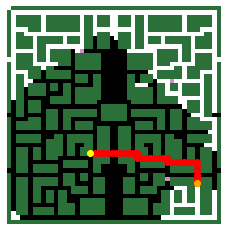

In [9]:
######### Breadth First Search #########

global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = breadth_first_graph_search(problem)
print("Path Solution Found: ", solution.solution())
print("Cost of the path found: ", solution.path_cost)
print("\nFinal maze:")
maze_array.show_maze(solution.solution())

total_visited_nodes["BFS"].append(np.count_nonzero(maze_array.maze == CellType.EMPTY))

Path Solution Found:  [(35, 19), (36, 19), (37, 19), (38, 19), (38, 18), (38, 17), (38, 16), (39, 16), (40, 16), (41, 16), (41, 17), (41, 18), (41, 19), (42, 19), (43, 19), (44, 19), (44, 20), (44, 21), (44, 22), (44, 23), (43, 23), (42, 23), (41, 23), (40, 23), (40, 24), (40, 25), (39, 25), (39, 26), (39, 27), (39, 28), (39, 29), (39, 30), (38, 30), (38, 31), (38, 32), (38, 33), (38, 34), (38, 35), (38, 36), (38, 37), (39, 37), (39, 38), (39, 39), (39, 40), (39, 41), (39, 42), (39, 43), (39, 44), (40, 44), (41, 44)]
Cost of the path found:  50

Final maze:


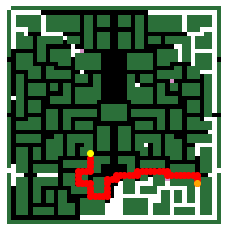

In [10]:
######### Depth Limited Search #########

global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = depth_limited_search(problem)
try:
    print("Path Solution Found: ", solution.solution())
    print("Cost of the path found: ", solution.path_cost)
    print("\nFinal maze:")
    maze_array.show_maze(solution.solution())
    total_visited_nodes["DLS"].append(np.count_nonzero(maze_array.maze == CellType.EMPTY))
except:
    total_visited_nodes["DLS"].append(np.count_nonzero(maze_array.maze == CellType.EMPTY))
    print("Path not found with depth limited = 50")

#### Medições de tempo para os algoritmos de busca não-informada

In [11]:
%%timeit -o
######### Breadth First Search #########

global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = breadth_first_graph_search(problem)

11.4 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 11.4 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [12]:
time_measure["BFS"].append(_.average)

In [13]:
%%timeit -o
######### Depth Limited Search #########
global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = depth_limited_search(problem)

8.04 ms ± 777 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 8.04 ms ± 777 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [14]:
time_measure["DLS"].append(_.average)

### Métodos de Busca Informada

#### Greedy Best First

Como um dos métodos de busca informada, aplicamos o Greedy Best First. Este algoritmo utiliza uma função heurística $F(n) = h(n)$ como uma estimativa do custo do caminho do nó atual até o estado final, expandindo para aquele que possui uma avaliação aparentemente melhor em relação ao objetivo. No caso do labirinto do Pac-man, o nó vizinho que apresenta o menor valor da função $h(n)$ é o escolhido para ser expandido. É um algoritmo guloso por sempre realizar localmente a melhor escolha. Como exemplo, imagine que um problema cujo objetivo seja chegar ao nó Y, sendo o nó X o estado inicial, cujos vizinhos são A, B e C, possuindo os seguintes valores para a função heurística $h(n)$:

![alt text](./figures/heuristic_example.jpeg)

O nó a ser expandido seria o B, pelo valor de $h(n)$ ser o menor dentre todos os vizinhos de X.

Este algoritmo possui:

- Complexidade de tempo e espaço $O(bm)$ no pior caso, porém boas heurísticas conseguem reduzir essa complexidade.
- Pode ser incompleto se na implementação não identificar estados repetidos.

Conforme modelamos o problema, este algoritmo sempre será completo pelo fato de não permitirmos que o Pac-man revisite posições. O uso das heurísticas de distância de manhattan e distância linear também garantem que a complexidade é menor que $O(bm)$.

#### A*

O algoritmo A* é uma combinação da estimativa de uma heurística $h(n)$ e da função custo para ir do nó atual até o vizinho $(g(n))$, resultando na seguinte função de avaliação: $f(n) = g(n) + h(n)$. Da mesma forma que no greedy best first, o nó a ser expandido é sempre o que apresenta a melhor avaliação em relação ao objetivo, no caso do Pac-man, o menor valor. Conforme modelamos o problema, o custo de $g(n)$ sempre será unitário para todos nós vizinhos, fazendo que na prática a heurística $h(n)$ seja a única responsável pelo resultado da função avaliação.

Este algoritmo possui:

- Complexidade de tempo e espaço $O(b^{d})$ no pior caso, porém o uso de boas heurísticas reduz essa complexidade.
- Pode ser ótimo e completo com a utilização de heurísticas consistentes.

Este algoritmo também sempre será completo pelo fato de não permitirmos que o Pac-man revisite posições. O uso das heurísticas de distância de manhattan e distância linear também garantem que a complexidade é menor que $O(b^{d})$.


Path Solution Found:  [(34, 20), (34, 21), (34, 22), (34, 23), (34, 24), (34, 25), (34, 26), (34, 27), (34, 28), (34, 29), (34, 30), (35, 30), (35, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (35, 37), (36, 37), (36, 38), (36, 39), (36, 40), (36, 41), (36, 42), (36, 43), (36, 44), (37, 44), (38, 44), (39, 44), (40, 44), (41, 44)]
Cost of the path found:  32

Final maze:


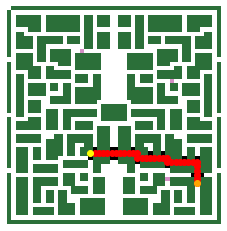

In [15]:
######### Greedy Best First with f() = linear distance #########

global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = best_first_graph_search(problem, linear)

print("Path Solution Found: ", solution.solution())
print("Cost of the path found: ", solution.path_cost)
print("\nFinal maze:")
maze_array.show_maze(solution.solution())
total_visited_nodes["GL"].append(np.count_nonzero(maze_array.maze == CellType.EMPTY))

Path Solution Found:  [(34, 20), (34, 21), (34, 22), (34, 23), (34, 24), (34, 25), (34, 26), (34, 27), (34, 28), (34, 29), (34, 30), (35, 30), (35, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (35, 37), (36, 37), (36, 38), (36, 39), (36, 40), (36, 41), (36, 42), (36, 43), (36, 44), (37, 44), (38, 44), (39, 44), (40, 44), (41, 44)]
Cost of the path found:  32

Final maze:


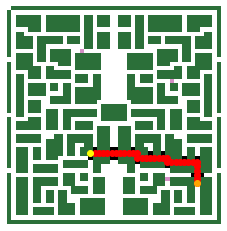

In [16]:
######### Greedy Best First with f() = manhatan distance #########

global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = best_first_graph_search(problem, manhatan)

print("Path Solution Found: ", solution.solution())
print("Cost of the path found: ", solution.path_cost)
print("\nFinal maze:")
maze_array.show_maze(solution.solution())
total_visited_nodes["GM"].append(np.count_nonzero(maze_array.maze == CellType.EMPTY))

Path Solution Found:  [(34, 20), (33, 20), (32, 20), (31, 20), (30, 20), (29, 20), (28, 20), (27, 20), (26, 20), (26, 19), (26, 18), (26, 17), (26, 16), (26, 15), (27, 15), (28, 15), (29, 15), (29, 14), (29, 13), (29, 12), (28, 12), (27, 12), (26, 12), (25, 12), (24, 12), (23, 12), (23, 11), (23, 10), (23, 9), (22, 9), (21, 9), (20, 9), (19, 9), (18, 9), (17, 9), (17, 8), (16, 8), (15, 8), (14, 8), (13, 8), (13, 7), (13, 6), (12, 6), (11, 6), (10, 6), (9, 6), (8, 6), (7, 6), (6, 6), (6, 5), (6, 4), (5, 4), (5, 3), (5, 2), (5, 1), (4, 1), (3, 1), (2, 1), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (2, 32), (3, 32), (4, 32), (5, 32), (6, 32), (6, 33), (6, 34), (6, 35), (6, 36), (7, 36), (8, 36), (9, 36), (9, 37), (9, 38), (9, 39), (9, 40), (10, 40), (11, 40

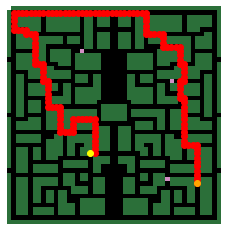

In [17]:
######### Greedy Best First with f() = inverse manhatan distance #########

global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = best_first_graph_search(problem, inverse_manhatan)

print("Path Solution Found: ", solution.solution())
print("Cost of the path found: ", solution.path_cost)
print("\nFinal maze:")
maze_array.show_maze(solution.solution())
total_visited_nodes["GIM"].append(np.count_nonzero(maze_array.maze == CellType.EMPTY))

Path Solution Found:  [(34, 20), (34, 21), (34, 22), (34, 23), (34, 24), (34, 25), (34, 26), (34, 27), (34, 28), (34, 29), (34, 30), (35, 30), (35, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (35, 37), (36, 37), (37, 37), (38, 37), (39, 37), (39, 38), (39, 39), (39, 40), (39, 41), (39, 42), (39, 43), (39, 44), (40, 44), (41, 44)]
Cost of the path found:  32

Final maze:


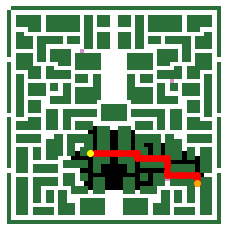

In [18]:
######### A* with h() = linear distance #########

global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = astar_search(problem, linear)

print("Path Solution Found: ", solution.solution())
print("Cost of the path found: ", solution.path_cost)
print("\nFinal maze:")
maze_array.show_maze(solution.solution())
total_visited_nodes["ASL"].append(np.count_nonzero(maze_array.maze == CellType.EMPTY))

Path Solution Found:  [(34, 20), (34, 21), (34, 22), (34, 23), (34, 24), (34, 25), (34, 26), (34, 27), (34, 28), (34, 29), (34, 30), (35, 30), (35, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (35, 37), (36, 37), (36, 38), (36, 39), (36, 40), (36, 41), (36, 42), (36, 43), (36, 44), (37, 44), (38, 44), (39, 44), (40, 44), (41, 44)]
Cost of the path found:  32

Final maze:


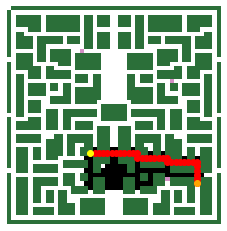

In [19]:
######### A* with h() = manhatan distance #########

global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = astar_search(problem, manhatan)

print("Path Solution Found: ", solution.solution())
print("Cost of the path found: ", solution.path_cost)
print("\nFinal maze:")
maze_array.show_maze(solution.solution())
total_visited_nodes["ASM"].append(np.count_nonzero(maze_array.maze == CellType.EMPTY))

Path Solution Found:  [(34, 20), (34, 21), (34, 22), (34, 23), (34, 24), (34, 25), (34, 26), (34, 27), (34, 28), (34, 29), (34, 30), (35, 30), (35, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (35, 37), (36, 37), (36, 38), (36, 39), (36, 40), (36, 41), (36, 42), (36, 43), (36, 44), (37, 44), (38, 44), (39, 44), (40, 44), (41, 44)]
Cost of the path found:  32

Final maze:


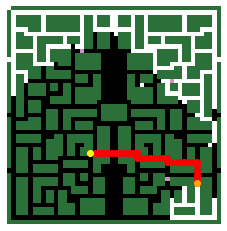

In [20]:
######### A* with h() = inverse manhatan distance #########

global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = astar_search(problem, inverse_manhatan)

print("Path Solution Found: ", solution.solution())
print("Cost of the path found: ", solution.path_cost)
print("\nFinal maze:")
maze_array.show_maze(solution.solution())
total_visited_nodes["ASIM"].append(np.count_nonzero(maze_array.maze == CellType.EMPTY))

#### Medições de tempo para os algoritmos de busca informada

In [21]:
%%timeit -o
######### Greedy Best First with f() = linear distance #########

global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = best_first_graph_search(problem, linear)

780 µs ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 780 µs ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [22]:
time_measure["GL"].append(_.average)

In [23]:
%%timeit -o
######### Greedy Best First with f() = manhatan distance #########

global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = best_first_graph_search(problem, manhatan)

823 µs ± 114 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 823 µs ± 114 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [24]:
time_measure["GM"].append(_.average)

In [25]:
%%timeit -o
######### Greedy Best First with f() = inverse manhatan distance #########

global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = best_first_graph_search(problem, inverse_manhatan)

21 ms ± 343 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 21 ms ± 343 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [26]:
time_measure["GIM"].append(_.average)

In [27]:
%%timeit -o
######### A* with h() = linear distance #########

global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = astar_search(problem, linear)

2.87 ms ± 244 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.87 ms ± 244 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [28]:
time_measure["ASL"].append(_.average)

In [29]:
%%timeit -o
######### A* with h() = manhatan distance #########
global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = astar_search(problem, manhatan)

2.1 ms ± 20.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.1 ms ± 20.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [30]:
time_measure["ASM"].append(_.average)

In [31]:
%%timeit -o
######### A* with h() = manhatan distance #########
global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = astar_search(problem, inverse_manhatan)

16.6 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 16.6 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [32]:
time_measure["ASIM"].append(_.average)

### Método de Busca Local

#### Hill Climbing

Para o algoritmo de busca local escolhemos o Hill Climbing. Esse algoritmo funciona como um loop que visa continuamente aumentar a função `value()` definida na nossa classe "PacmanMazeProblem".

Definimos nossa função `value()` como o número de dots coletados pelo Pac-man, de modo que o Hill Climbing agisse de forma a maximizar esse valor. Vale pontuar que esse é o único objetivo desse algoritmo, ou seja, através dele o Pac-man não chegará ao ponto objetivo que foi definido anteriormente e utilizados nas buscas anteriores.

O Hill Climbing não é completo, nem ótimo. Uma limitação que podemos pontuar desse algoritmo é que ele pode ficar preso em máximos locais, uma vez que não possui nenhum mecanismo que possubilite voltar atrás alguns passos para encontrar uma saída melhor.

Esse algoritmo possui:
- Complexidade de tempo no melhor caso de $O(d)$ e no pior caso de $O(b^{d})$, onde b é o número médio de sucessores de um nó e d a profundidade da solução encontrada.
- Como complexidade de memória, esse algoritmo não precisa manter nós na memória.

Number of eaten dots:  119


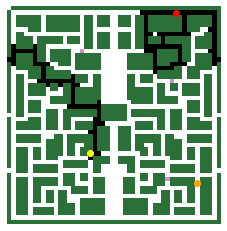

In [33]:
######### Hill Climbing Local Search #########
maze_array.maze = maze_array.original_maze.copy()
solution = hill_climbing(problem)
print("Number of eaten dots: ", solution[2])
maze_array.show_maze([(solution[0], solution[1])])
total_visited_nodes["HC"].append(np.count_nonzero(maze_array.maze == CellType.EMPTY))

#### Medição de tempo para o algoritmo Hill Climbing 

In [34]:
%%timeit -o
######### Hill Climbing Local Search #########
global maze_array
maze_array.maze = maze_array.original_maze.copy()
solution = hill_climbing(problem)

691 µs ± 69.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 691 µs ± 69.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [35]:
time_measure["HC"].append(_.average)

## Análises de Tempo e Memória

Para as análises de tempo e memória dos algoritmos de busca realizamos 15 experimentos. Em cada um deles, variamos toda configuração do labirinto mantendo apenas o tamanho do grid e, em cada experimento, coletamos a média do tempo de execução e o total de nós visitados pelo Pac-man.

#### Memória

A tabela abaixo contém o número total de nós visitados por cada busca para os 15 experimentos e, na última coluna, temos a distância de manhatan entre a posição inicial do Pac-man e o objetivo.
![alt text](./figures/search_memory.png)


Para efeito das análises a seguir, observamos que, dado a forma com que modelamos nosos problema, a quantidade de nós visitados e avaliados é a mesma.

Podemos observar que para todos os algoritmos de busca, exceto Hill Climbing, nenhum chegou na menor quantidade de nós visitados possível, ou seja, em um valor igual a distância de manhatan entre o Pac-man e o Objetivo. Isso já era esperado pois, como organizamos as ações possíveis seguindo as direções Oeste, Norte, Sul e Leste nessa ordem, não temos garantido que o objetivo estará no caminho da primeira direção tomada pelo algoritmo.

Dentre os algoritmos de busca não informada, temos que em 10 dos 15 experimentos a Busca Limitada em Profundidade precisou visitar menos nós que a Busca em Largura. Mesmo apresentando melhor performance a Busca Limitada em Profundiodade nem sempre consegue encontrar o objetivo, já que está limitada há uma profundidade máxima, portanto é necessário cautela ao definir o limite em relação ao tamanho do labirinto.

Utilizando como heurística a Distância Linear entre o Pac-man e o Objetivo, temos que a "Best First Search" apresentou uma performance melhor que o algoritmo A*. Podemos atribuir esse melhor desempenho em termos de memória ao fato desse algoritmo levar em consideração somente a heuristica e que, no caso do problema proposto, isto leva este algoritmo ao menor caminho sem desviar.

Utilizando como heurística a Distância de Manhatan entre o Pac-man e o Objetivo, temos que a "Best First Search" apresentou um número de nós visitados ligeiramente menor que o algoritmo A*. Como essa diferença foi muito pequena, consideramos que os dois algoritmos tiveram desempenho similar para os experimentos executados.

Para a heurística da Distância de Manhatan Inversa, como o objetivo era visitar mais nós ao longo do caminho até o Objetivo, a heurística se mostrou mais eficiente para o Best First Search que visitou certa de 1000 nós em cada experimento. 

Caso nosso objetivo fosse chegar ao ponto final com o maior caminho  sem revisitar nós (para o fim do Pac-man coletar a maior quantidade de pontos), o algoritmo que melhor desempenha esse papel é o Best First Search utilizando a heurística da distância de manhattan inversa.


#### Tempo

<!-- Para analisar o tempo de execução de cada algoritmo de busca realizamos 15 experimentos. Em cada um deles, variamos toda configuração do labirinto mantendo apenas o tamanho do grid. Coletamos a média do tempo de execução em cada experimento e plotamos em função da distância de manhattan entre a posição inicial do Pac-man e o objetivo. 
 -->
 
A partir das médias dos tempos de execução coletadas, plotamos em função da distância de manhattan entre a posição inicial do Pac-man e o objetivo. 

 
![alt text](./figures/search_times.png)


Pelo gráfico acima, podemos perceber que o algoritmo mais rápido é o Hill Climbing, porém, esse fato acaba não tendo relevância para a resolução do problema por conta do Pac-man não chegar ao objetivo final em alguns casos.

Também fica claro que os algoritmos de busca não informada na maioria das vezes possuem uma performance de tempo pior que os de busca informada, principalmente pelo fato de utilizarem apenas uma função de enfileiramento como único conhecimento para determinar o próximo passo rumo a uma solução final (força bruta), enquanto os algoritmos de busca informada utilizam uma função de avaliação como uma forma de mensurar a probabilidade de um nó convergir para uma solução baseado em seu estado corrente.

A alta taxa de crescimento do tempo em relação a distância do algoritmo de busca em largura também evidencia que, neste problema do Pac-man, este pode ser uma péssima escolha para labirintos maiores.

Dentre os algoritmos de busca informada, o best first search obteve o melhor resultado geral independente da heurística utilizada, com pouca flutuação de tempo entre todas as distância até o objetivo.

Outro ponto que foi possível observarmos nos testes que realizamos foi que, caso o caminho até o objetivo encontre-se numa das primeiras sub-árvores que o algoritmo de profundidade percorre, sua performance de tempo pode ser melhor que o A* com heurística de distância linear. Entretanto, não podemos considerar isso como uma ocorrência geral, pelo fato dessa situação não acontecer sempre com determinado conjunto de características, sendo ocasional.

## Conclusão

Com a utilização de algoritmos de busca informada, não-informada e busca local foi possível encontrar um caminho para o Pac-man até o Objetivo, desviando dos fantasmas estáticos no mapa. A busca que se mostrou mais eficiente comparando tempo e espaço foi a Best First Search tanto utilizando como heurística distância linear quanto a distância de manhatan. Já o algoritmo que comeu mais dots foi também o Best First Search utilizando como heurística a distância de Manhatan inversa. O algoritmo com pior desempenho de tempo foi o de busca em largura, podendo apresentar um problema de performance de tempo grande em casos de labirintos maiores.

Além disso, podemos observar que o desempenho de tempo e memória dos algoritmos de busca informada possuem uma forte relação com a escolha das heurísticas. O uso de heurísticas admíssiveis garante a otimização do objetivo, como por exemplo, alcançar o Pac-man pelo menor caminho. Outro fato é que apenas mudando a heurística, também conseguimos alterar drasticamente o comportamento do algoritmo best first search, mostrando que além de mais performático, seu comportamento é facilmente customizado pela troca da heurística, como mostramos com a distância manhattan inversa.

Por fim, podemos concluir que o desempenho de uma solução para um problema de busca apresenta forte relação com o conhecimento das características de cada algoritmo. Apesar da maioria conseguir alcançar uma solução, fica claro a diferença de tempo e memória entre eles. Isso também possui forte relação com a modelagem do problema, uma vez que a definição de elementos como ações e estados podem favorecer a aplicação de alguns algoritmos em relação aos demais.


## Referências

[1] Aima-python: search. Disponível online em https://github.com/aimacode/aima-python/blob/master/search.py

[2] pacman-mazegen: walls. Disponível online em https://github.com/shaunlebron/pacman-mazegen/blob/gh-pages/randomfill/walls.py




## Tarefas

Modelagem e documentação: todos.

Buscas não informada: Andreza.

Buscas informadas: Daniela e Guilherme.

Busca local: Thamiris.

Heurísticas: Lucas e Guilherme.

Vídeo: Lucas.
